In [6]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

from utils.plot_utils import newplot

from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
GPUs Available:  []


In [7]:


train = 1
val = 50000
test = 50000

epochs = 50
batch_size=512
callbacks =None
verbose = 2



# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)




# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

X = np.array(features)





Data loaded!


# k = 1

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100)               0   

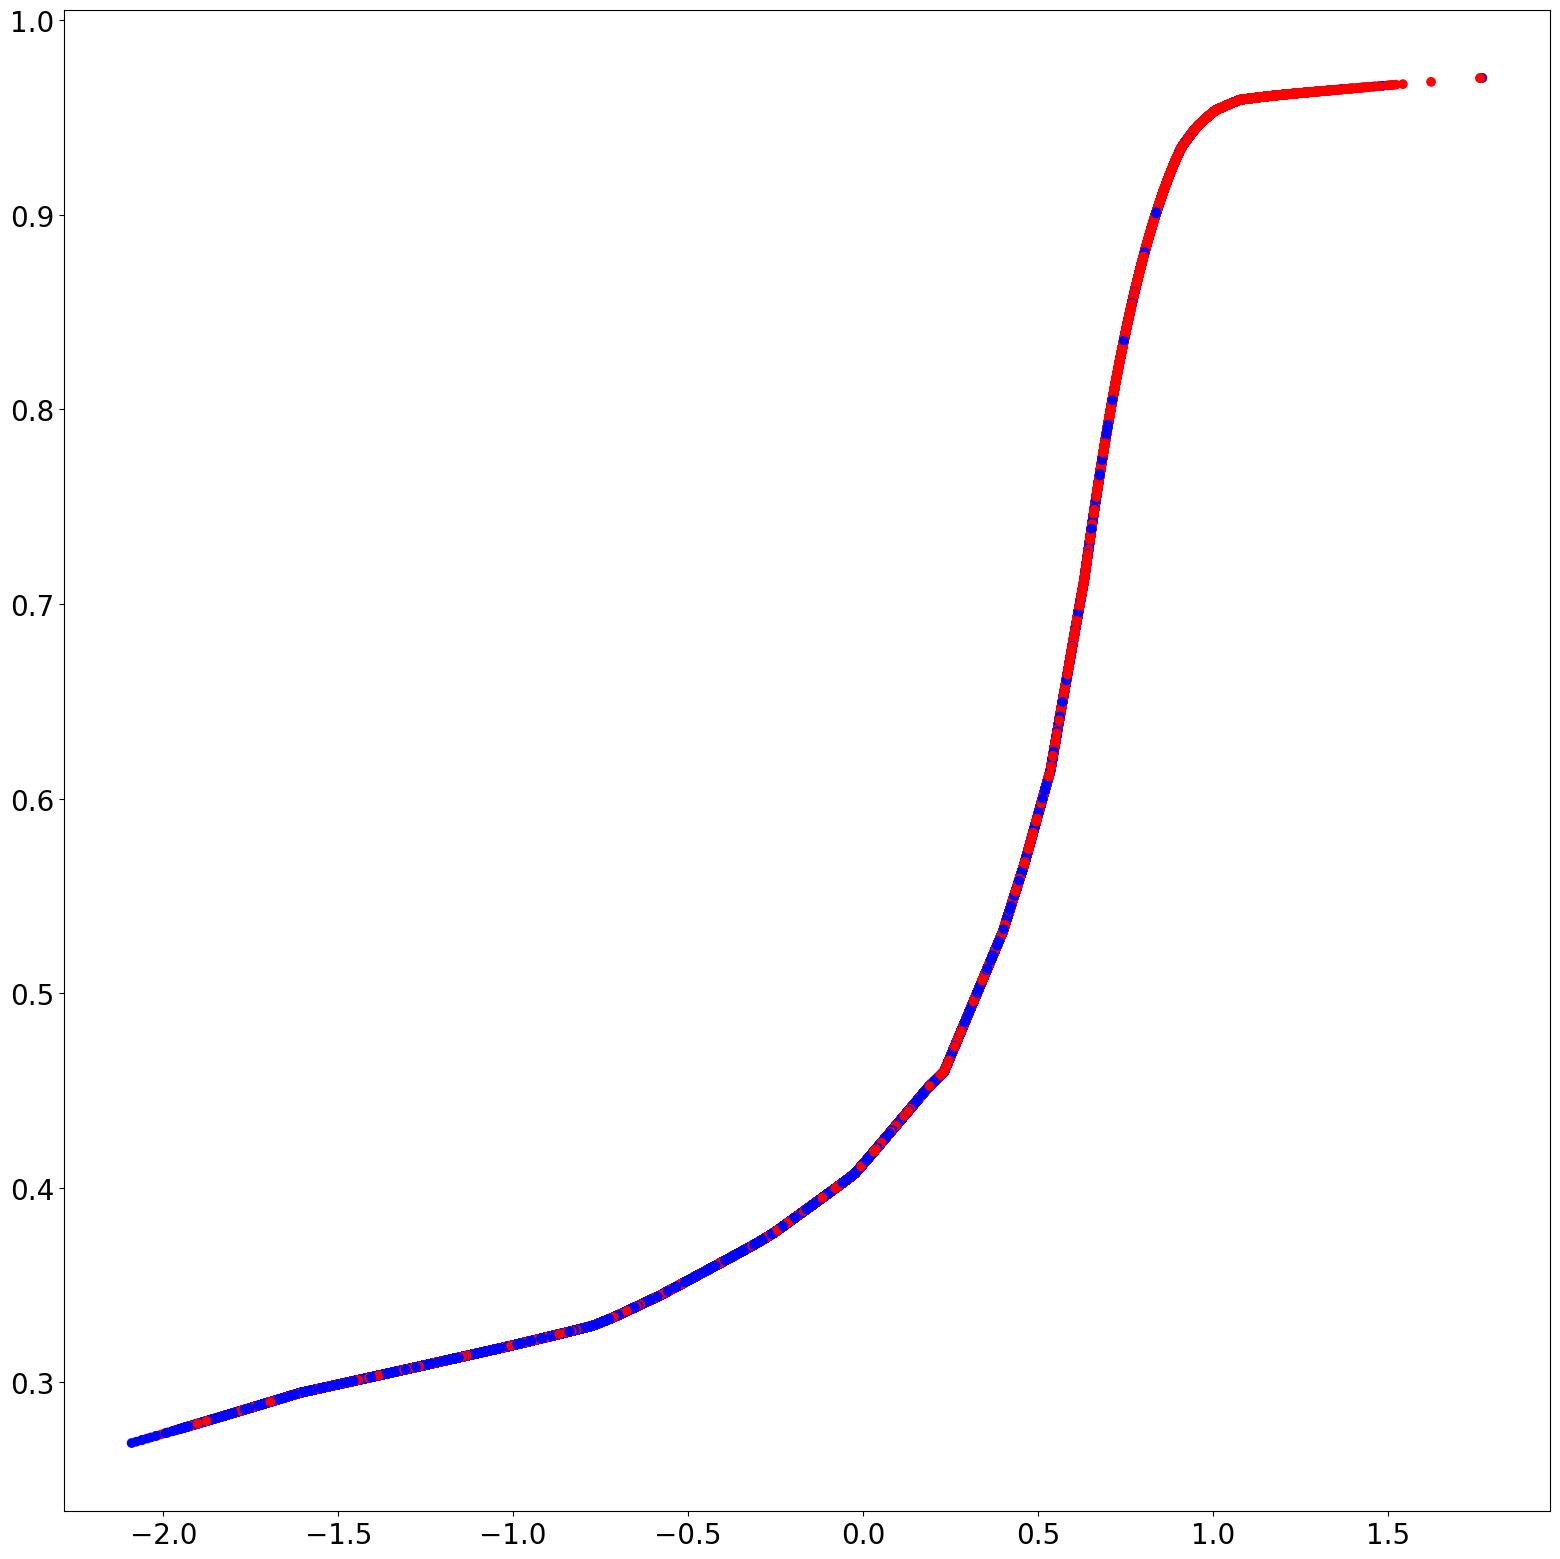

In [8]:
rocs = []
k_order = 1

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

plt.scatter(X_test[:,1], preds, c = Y_test[:,1], cmap="bwr")



# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               400       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 100)               0   

Text(0, 0.5, '$\\mathcal{O}^{(2)}$')

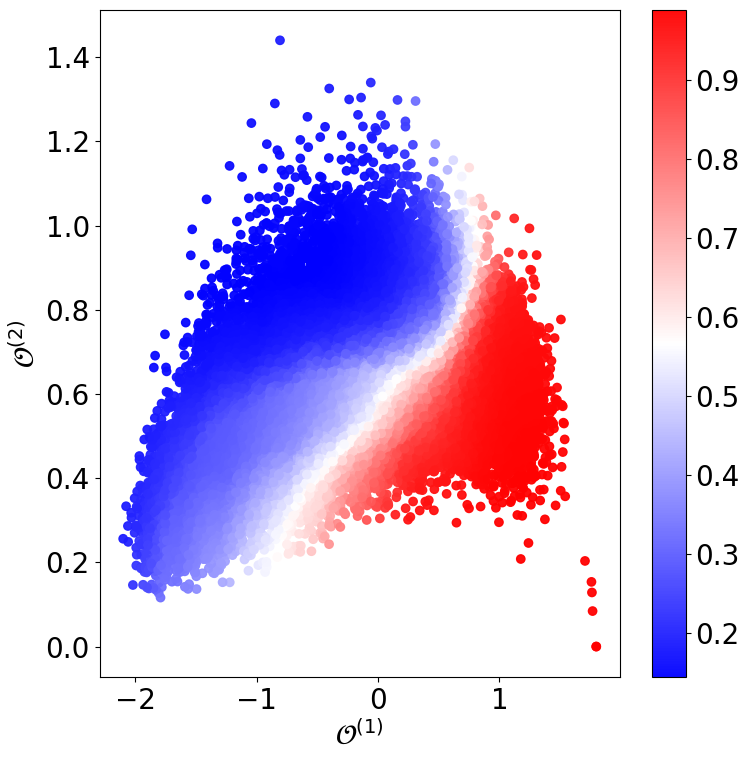

In [13]:
rocs = []
k_order = 2

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]



# Plot

newplot()
plt.scatter((X_test[:,1]), (X_test[:,2] - (X_test[:,1]**2)), c = preds, cmap="bwr", alpha = 0.95, edgecolors= None)


# plt.plot(np.linspace(-2, 2, 150),np.sqrt(np.linspace(-2, 2, 150)**2), color = "black", alpha = 0.5, ls = "--", label = "Bound" )


plt.colorbar(cmap = "bwr")
plt.xlabel(r"$\mathcal{O}^{(1)}$")
plt.ylabel(r"$\mathcal{O}^{(2)}$")



# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()

# k = 3

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               500       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 100)               0   

/tmp/ipykernel_19567/568825249.py:24: RuntimeWarning: invalid value encountered in power
  ax.scatter(X_test[:,1], np.sqrt(X_test[:,2]), np.power(X_test[:,3], 1/3), c = preds, cmap="bwr")


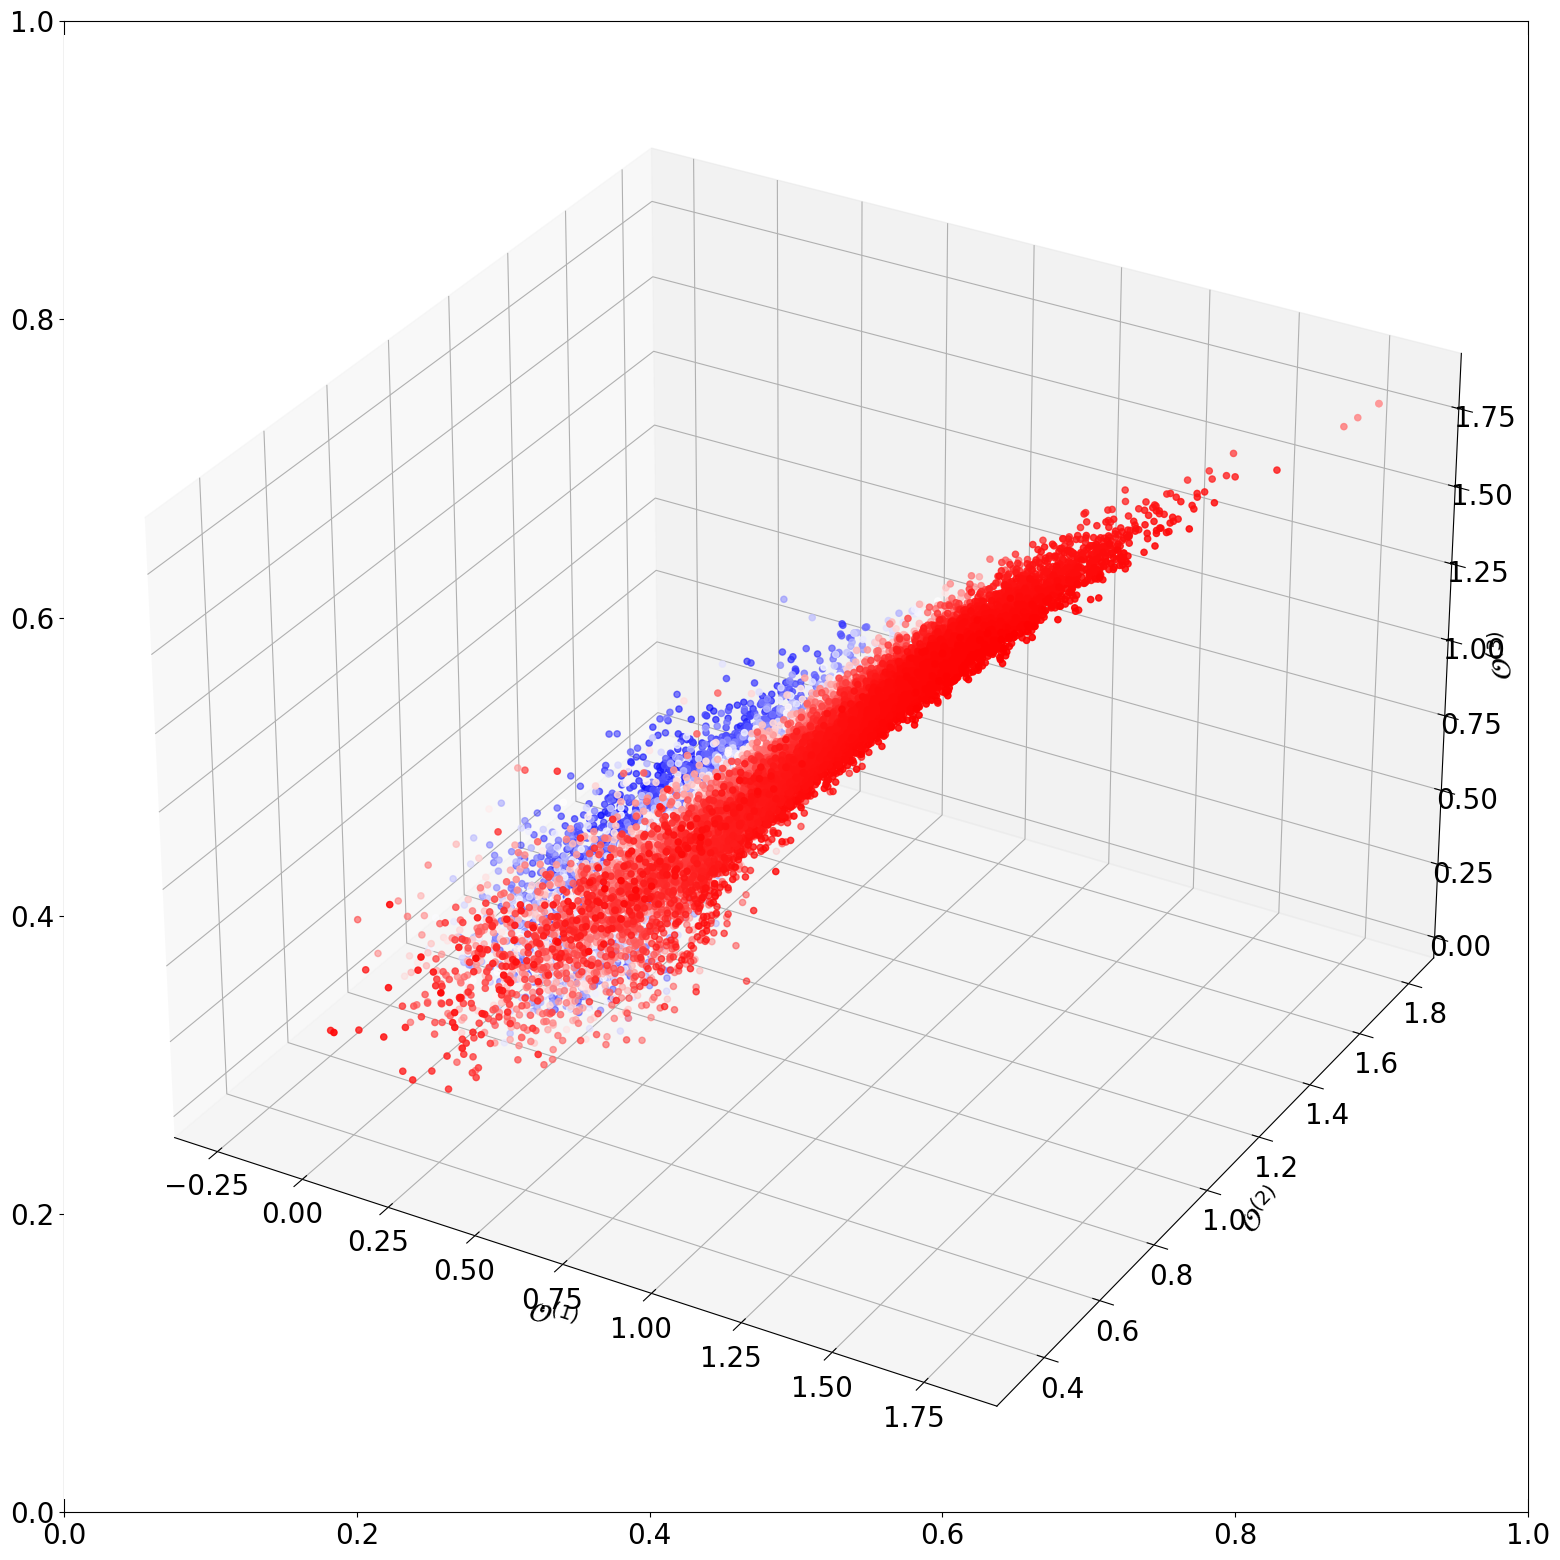

In [10]:
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D


rocs = []
k_order = 3

fig, ax = newplot(width = 16, height = 16)
ax = fig.add_subplot(projection='3d')

(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

# train model
dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)[:,1]

ax.scatter(X_test[:,1], np.sqrt(X_test[:,2]), np.power(X_test[:,3], 1/3), c = preds, cmap="bwr")
# ax.set_colorbar(cmap = "bwr")
ax.set_xlabel(r"$\mathcal{O}^{(1)}$")
ax.set_ylabel(r"$\mathcal{O}^{(2)}$")
ax.set_zlabel(r"$\mathcal{O}^{(3)}$")


plt.show()

# for k_order in [1, 2, 3, 4]:


#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(X[:,:k_order+1], Y, val=val, test=test)

#     dense_sizes = (100, 100, 100)

#     dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.load_weights(f"Data/dnn/dnn_O{k_order}.keras")

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()